<a href="https://colab.research.google.com/gist/worona-upb/fbc2f5c6d6e0ff59e5bb51bce4023a41/01_data_understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config

## Online

Das Notebook kann mit unserem vollständigen finalen Modell online auf https://colab.research.google.com und dem [Google-Drive-Ordner](https://drive.google.com/drive/folders/1uGUhBHv95S7T_YHfX-radjUapn1B5GHb?usp=sharing) ("Add to My Drive"/"Zu Meine Ablage hinzufügen" erforderlich) ausgeführt werden. Dabei werden die Modelle aus dem Drive-Ordner geladen.

## Lokal

Ansonsten müssen folgende Konfigurationsparameter angepasst werden:

- `dataset_folder_name`: Ordner, der den Yelp-Datensatz (.csv) enthält
    - Benötigt werden die Tabellen "category", "business" und "review"
- `table_name_template`: Dateinamenformat
    - `{table_name}` wird in der Funktion `load_table` durch den jeweiligen Tabellennamen ersetzt

In [0]:
dataset_folder_name = "yelp_data"
table_name_template = "yelp_db_{table_name}.csv"

In [0]:
try:
    INSIDE_COLAB = get_ipython().config.IPKernelApp.kernel_class == "google.colab._kernel.Kernel"
except Exception:
    INSIDE_COLAB = False

In [0]:
!pip install -U tqdm fastparquet matplotlib seaborn

In [0]:
if INSIDE_COLAB:
    from google.colab import drive

import json
import os
import random

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()

In [0]:
if INSIDE_COLAB:
    mount_directory = "/gdrive"
    dataset_directory = os.path.join(mount_directory, "My Drive", dataset_folder_name)
else:
    dataset_directory = dataset_folder_name


def p(*path):
    """Utility function to create a path to dataset directory."""
    return os.path.join(dataset_directory, *path)


review_csv_kwargs = {
    "parse_dates": [2],
    "infer_datetime_format": True
}

def load_table(table_name):
    """Load a yelp database table by its name."""

    kwargs = review_csv_kwargs if table_name == "review" else {}

    return pd.read_csv(
        p(table_name_template.format(table_name=table_name)),
        **kwargs
    )


class PATHS:
    """Collections of paths used in this notebook."""

    food_reviews = p("yelp_db_review_food.parquet")


def save_parquet(df, path):
    """Save a dataframe in parquet format."""

    print(f"Speichere {path!r}...")
    df.to_parquet(path, engine="fastparquet", index=True, compression="gzip")

def load_parquet(path):
    """Load a dataframe in parquet format."""

    print(f"Lade {path!r}...")
    return pd.read_parquet(path, engine="fastparquet")

In [0]:
if INSIDE_COLAB:
    from google.colab import drive
    drive.mount(mount_directory)

# Datensätze laden

In [7]:
%%time

cat_df = load_table("category")
bus_df = load_table("business")
rev_df = load_table("review")

CPU times: user 45.6 s, sys: 9.34 s, total: 54.9 s
Wall time: 1min 6s


# Nach Food-Kategorien filtern

Siehe https://www.yelp.com/developers/documentation/v3/all_category_list

In [0]:
irrelevant_food_categories = [
    "Beer, Wine & Spirits",
    "Butcher",
    "CSA",
    "Coffee & Tea Supplies",
    "Coffee Roasteries",
    "Convenience Stores",
    "Distilleries",
    "Do-It-Yourself Food",
    "Ethical Grocery",
    "Farmers Market",
    "Fishmonger",
    "Food Delivery Services",
    "Grocery",
    "Honey",
    "Imported Food",
    "International Grocery",
    "Internet Cafes",
    "Kiosk",
    "Kombucha",
    "Meaderies",
    "Mulled Wine",
    "Organic Stores",
    "Parent Cafes",
    "Specialty Food",
    "Water Stores",
    "Wineries"
]

In [0]:
food_cats = cat_df[cat_df.category.isin(["Restaurants", "Food"])]

In [0]:
irrelevant_bus_ids = cat_df[cat_df.category.isin(irrelevant_food_categories)].business_id.drop_duplicates()
food_bus_ids = food_cats.business_id.drop_duplicates()
food_bus_ids = food_bus_ids[~food_bus_ids.isin(irrelevant_bus_ids)]

In [0]:
food_reviews_path = p("yelp_db_review_food.parquet")

In [12]:
%%time

food_bus_df = bus_df[bus_df.id.isin(food_bus_ids)]

if not os.path.exists(food_reviews_path):
    food_rev_df = rev_df[rev_df.business_id.isin(food_bus_df.id)].set_index("id")
    save_parquet(food_rev_df, food_reviews_path)
else:
    food_rev_df = load_parquet(food_reviews_path)

Lade '/gdrive/My Drive/yelp_data/yelp_db_review_food.parquet'...
CPU times: user 24.8 s, sys: 11.3 s, total: 36.1 s
Wall time: 52.3 s


In [13]:
print("     Businesses: ", f"{len(bus_df):,}".replace(",", " ").rjust(9))
print("Food Businesses: ", f"{len(food_bus_df):,}".replace(",", " ").rjust(9))
print("   Food Reviews: ", f"{len(food_rev_df):,}".replace(",", " ").rjust(9))

print()

reviews_per_day = len(food_rev_df) // (
    food_rev_df.date.max() - food_rev_df.date.min()
).days
print("Reviews pro Tag: ", f"~{reviews_per_day}".rjust(9))

     Businesses:    156 639
Food Businesses:     56 572
   Food Reviews:  2 993 393

Reviews pro Tag:       ~629


No handles with labels found to put in legend.
No handles with labels found to put in legend.


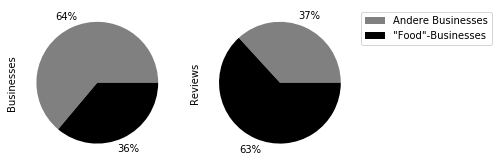

In [14]:
food_bus_ratio_plot = pd.DataFrame({
    "Businesses": [len(bus_df) - len(food_bus_df), len(food_bus_df)],
    "Reviews": [len(rev_df) - len(food_rev_df), len(food_rev_df)]},
    index=["Andere Businesses", '"Food"-Businesses']
).plot.pie(
    autopct='%1.0f%%',
    pctdistance=1.2,
    colors=["gray", "black"],
    labels=None,
    subplots=True
)

food_bus_ratio_plot[0].get_legend().remove()
food_bus_ratio_plot[1].legend(labels=["Andere Businesses", '"Food"-Businesses'], bbox_to_anchor=(1, 1))

In [0]:
food_bus_ratio_plot[0].figure.savefig("food-bus-ratio.pdf", bbox_inches="tight")

In [0]:
del bus_df

In [0]:
df = rev_df

# Statistiken

Text(0, 0.5, 'Review-Anzahl (Monat)')

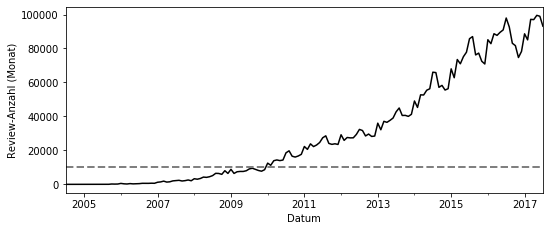

In [20]:
revs_time_plot = df.groupby(df.date.dt.to_period("M")).size().plot(color="k", figsize=(8.55, 3.42))
revs_time_plot.axhline(y=10_000, linestyle="--", color="gray", linewidth=2)
revs_time_plot.set_xlabel("Datum")
revs_time_plot.set_ylabel("Review-Anzahl (Monat)")

In [0]:
revs_time_plot.figure.savefig("food-rev-time.pdf", bbox_inches="tight")

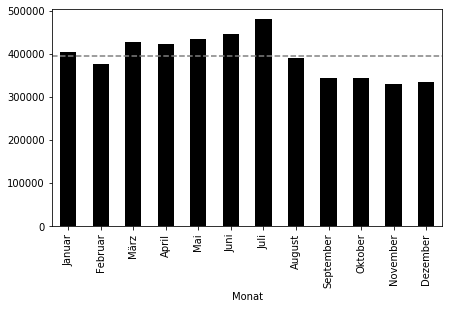

In [22]:
revs_each_month_plot = (
    df.groupby(df.date.dt.month).size().rename({
        1: "Januar",
        2: "Februar",
        3: "März",
        4: "April",
        5: "Mai",
        6: "Juni",
        7: "Juli",
        8: "August",
        9: "September",
        10: "Oktober",
        11: "November",
        12: "Dezember"
    }).plot.bar(color="k", figsize=(7, 4))
)
revs_each_month_plot.set_xlabel("Monat")
revs_each_month_plot.axhline(df.groupby(df.date.dt.month).size().mean(), linestyle="--", color="gray")

In [0]:
revs_each_month_plot.figure.savefig("food-rev-month-agg.pdf", bbox_inches="tight")

Text(0, 0.5, 'Anzahl Reviews')

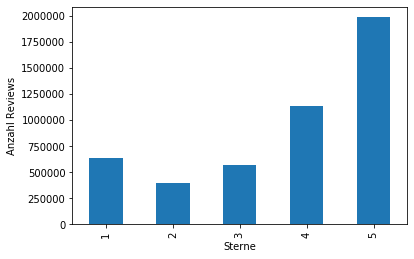

In [24]:
ax = rev_df.stars.astype("category").value_counts(sort=False).plot.bar()
ax.set_xlabel("Sterne")
ax.set_ylabel("Anzahl Reviews")

In [0]:
ax.figure.savefig("stars_dist.pdf", bbox_inches="tight")

In [26]:
df['length'] = df['text'].apply(len)
df.head()

,id,stars,date,text,useful,funny,cool,business_id,user_id,length
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w,322
1,---0hl58W-sjVTKi5LghGw,4,2016-07-24,Ate the momos during the momo crawl.. Was the ...,0,0,0,Ae4ABFarGMaI5lk1i98A0w,Y6qylbHq8QJmaCRSlKdIog,137
2,---3OXpexMp0oAg77xWfYA,5,2012-04-07,Pizza here made my night... Good people and gr...,2,0,0,lKq4Qsz13FDcAVgp49uukQ,SnXZkRN9Yf060pNTk1HMDg,108
3,---65iIIGzHj96QnOh89EQ,5,2015-09-11,Great brisket sandwich as claimed. Weird that ...,0,0,0,6nKR80xEGHYf2UxAe_Cu_g,VcmSgvslHAhqWoEn16wjjw,113
4,---7WhU-FtzSUOje87Y4uw,5,2016-01-22,"Interesting food, great atmosphere, and great ...",1,1,1,Z_mJYg3vi8cPZHa1J4BALw,NKF9v-r0jd1p0JVi9h2T1w,200


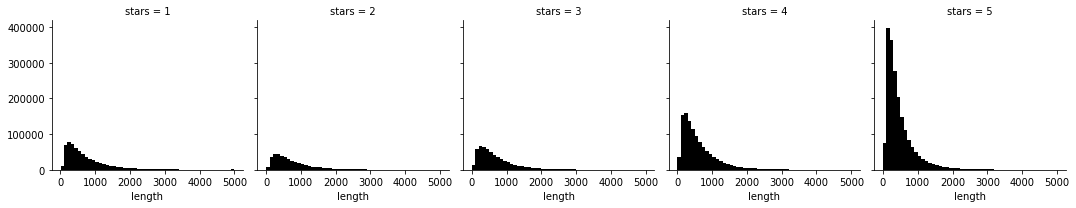

In [32]:
graph = sns.FacetGrid(data=df,col='stars')
ax = graph.map(plt.hist,'length',bins=50,color='black')

In [0]:
ax.savefig("stars_len.pdf", bbox_inches="tight")

In [35]:
!zip ./graphs.zip ./*.pdf

updating: food-bus-ratio.pdf (deflated 33%)
updating: food-rev-month-agg.pdf (deflated 32%)
updating: food-rev-time.pdf (deflated 30%)
updating: stars_dist.pdf (deflated 35%)
  adding: stars_len.pdf (deflated 23%)
